# Julia for Economists
## Automatic Differentiation and Optimization
### Cameron Pfiffer (cpfiffer@stanford.edu)

# Who am I?

- I'm Cameron Pfiffer, a PhD student in finance at the University of Oregon.
- I'm visiting at the Stanford GSB
- I work on Bayesian econometrics, asset pricing, industrial organization, and general computer go-fast stuff
- I'm doing a 5-part series on Julia for economists. 
- Howdy!

# What are we doing today?

- **Automatic differentiation**: how to get exact derivatives for arbitrary code
- **Optimization**: how to optimize most functions with Julia tools
- Lecturing with intermittent periods for you to practice concepts
- We go from 9am-1pm, with breaks at the top of each hour
- Ask questions when needed! Feel free to interrupt me.
- If you need a refresher about basics, please ask!

## Resources

Everything done here will be available on the GitHub repo for this course:
    
https://github.com/cpfiffer/julia-bootcamp-2022

## Automatic differentiation

We often have functions we want to take the derivative/gradient/Jacobian/Hessian of for various reasons:

- Derivatives help us optimize functions (the big one for our purposes today)
- Derivatives often have economic intuition on their own (marginal utility/marginal cost/etc.)



A common way one might work with derivatives in their research is simply to take an analytic derivative.

For example, let's look at the following function $f(x)$:

$$
f(x) = \sin(x^2)
$$

If we want $d f(x) / dx$, we can calculate this with the chain rule:

$$
\frac{df(x)}{dx} = \frac{d \sin(x^2)}{dx} = \cos(x^2) \frac{d x^2}{dx} = 2x \cos(x^2) 
$$

In Julia, this would be written up as

In [1]:
f(x) = sin(x^2)
df(x) = 2 * x * cos(x^2)

df (generic function with 1 method)

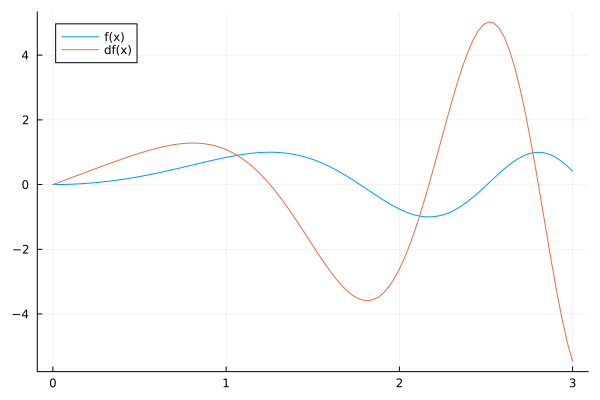

In [2]:
using Plots

# 100 values of x from 0,3
xs = range(0, 3, length=100)
plot(xs, f, label="f(x)")
plot!(xs, df, label="df(x)")

Sometimes, however, it's a massive pain to calculate analytic derivatives. Maybe you have a lot of parameters to keep track of. 

Enter _automatic differentiation_. This is how we can get `df(x)` without doing boring old _normal_ math!

## Automatic differentiation (autodiff)

Automatic differentiation is simply a programmatic way of handling the chain rule. There are two "modes" of autodiff, called "reverse mode" and "forward mode".

Both modes yield the same derivative, but get there different ways.

- Forward mode calculates derivatives from the __inside out__
- Reverse mode calculates derivatives from the __outside in__

I will talk later about which is "better", but for right now the gist is that forward mode is good for small numbers of parameters, and reverse mode is good for large numbers of parameters (for scalar functions).

I'm not going to dig into how these work! 

I just want you to limp along for now, and going through the details of AD is not particularly important until you start writing your own AD rules.

There's oodles of resources on AD and how they work, but for our purposes I just want you to understand how to hook them up.

A good resource is the `ChainRules.jl` [documentation](https://juliadiff.org/ChainRulesCore.jl/dev/maths/propagators.html).

Let's do some tinkering around. Please install ReverseDiff.jl and ForwardDiff.jl using

```julia
] add ReverseDiff ForwardDiff
```

or 

```julia
import Pkg
Pkg.add(["ReverseDiff", "ForwardDiff"])
```

There are other packages that work differently (`Zyogte.jl`, `Tracker.jl`, and a few others) but I'm going to leave these aside for now.

Once those are installed, let's tinker around with how they work. 


Let's only `import` them -- don't call `using` for now since the packages export similarly named functions.

For `ForwardDiff`, we can use `ForwardDiff.derivative(f, x)`.

`ReverseDiff` only works with array inputs, so I'm going to use `ReverseDiff.gradient(f, x)`, with some modifications.

For completeness I'll show how to use `gradient` for ForwardDiff as well.

In [4]:
import ReverseDiff, ForwardDiff

f(x) = sin(x^2)

exact_df(x) = 2*x*cos(x^2)
forward_df(x) = ForwardDiff.derivative(f, x)
forward_grad_df(x) = ForwardDiff.gradient(z -> f(z[1]), [x])[1]
reverse_df(x) = ReverseDiff.gradient(z -> f(z[1]), [x])[1]

@info "AD Examples" exact_df(1.0) reverse_df(1.0) forward_df(1.0) forward_grad_df(1.0)


┌ Info: AD Examples
│   exact_df(1.0) = 1.0806046117362795
│   reverse_df(1.0) = 1.0806046117362795
│   forward_df(1.0) = 1.0806046117362795
│   forward_grad_df(1.0) = 1.0806046117362795
└ @ Main c:\Users\chadi\OneDrive - Handelshögskolan i Stockholm\GitHub\julia-bootcamp-2022\session-3\optimization-lecture.ipynb:10


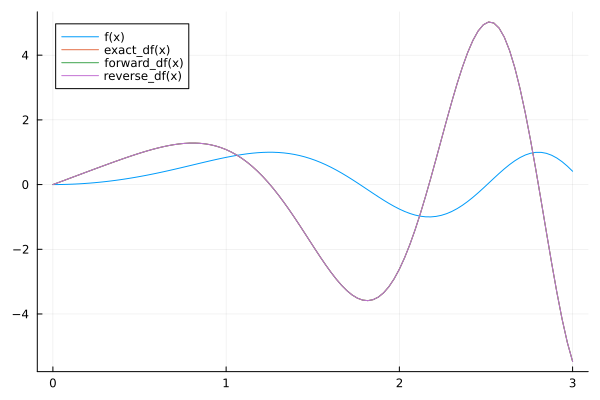

In [5]:
xs = range(0, 3, length=100)
plot(xs, f, label="f(x)")
plot!(xs, exact_df, label="exact_df(x)")
plot!(xs, forward_df, label="forward_df(x)")
plot!(xs, reverse_df, label="reverse_df(x)", legend=:topleft)

# Concept check!

Let's expand what we've worked with into general multivariate functions.

Take the loss function for OLS, as an example.

$$
f(\beta, X, Y) = (Y- X\beta)'(Y- X\beta)
$$

Use `ForwardDiff` and/or `ReverseDiff` to calculate the gradient w.r.t. $\beta$, $\nabla f(\cdot)$, at $\hat \beta = (X'X)^{-1}X'Y$. This gradient should be approximately zero for both, since $\hat \beta$ is the exact analytic value that minimizes the gradient.

__Bonus points__: Find $\hat \beta$ by grid search -- generate a grid of betas, evaluate their gradients, and return the beta with a gradient closest to zero.

Use the following code to generate data for $X$ and $Y$:

In [6]:
using LinearAlgebra # You'll need the inv(...) function to calculate an inverse

n = 100
beta = [1.0, 2.2]
X = [ones(n) rand(n)]
Y = X*beta + randn(n)
beta_hat = inv(X'X)*X'Y;

In [7]:
f(b) = (Y - X*b)' * (Y - X*b)
df(b) = ReverseDiff.gradient(f, b)

df(beta_hat)

2-element Vector{Float64}:
 3.410605131648481e-13
 1.1146639167236572e-13

## AD (usually) works on any function

A really cool thing is you can write really gnarly functions and get their derivatives easily and quickly. For example:

In [8]:
using ForwardDiff, Distributions
choosy(arr) = choosy(arr...)
function choosy(x, μ, σ)
    if x >= 1
        return logpdf(LogNormal(μ, σ), x)
    elseif x <= -1
        return logpdf(Normal(μ, σ), x) 
    else
        return logpdf(Beta(15, 12), abs(x)) * sin(μ) * cos(σ)
    end
end

println(ForwardDiff.gradient(choosy, [1.0, 2.0, 3.0]))
println(ForwardDiff.gradient(choosy, [0.5, 2.0, 3.0]))
println(ForwardDiff.gradient(choosy, [-1.2, 2.0, 3.0]))
# rng = 

[-0.7777777777777778, -0.2222222222222222, -0.18518518518518517]
[-5.4011857784131045, 0.5106491996000274, -0.15905184440444453]
[0.3555555555555555, -0.3555555555555555, 0.04592592592592598]


# AD woes

The way that our two AD packages work is that they change the underlying type of your input.

What does this mean? 

__Do not make your functions too type constricted if you want to get their derivative!__

Let me show you what I mean.


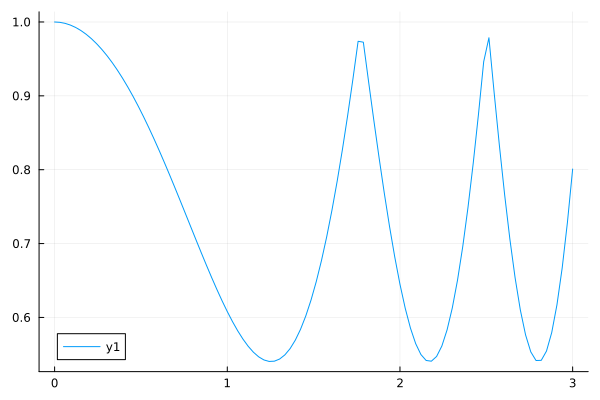

In [12]:
function g_basic(x::Float64)
    return cos(sqrt(abs(sin(x^2))))
end

xs = range(0, 3, length=100)
plot(xs, g_basic)

Now let's try and take a derivative.

In [13]:
ForwardDiff.derivative(g_basic, 1.0)

MethodError: MethodError: no method matching g_basic(::ForwardDiff.Dual{ForwardDiff.Tag{typeof(g_basic), Float64}, Float64, 1})

Closest candidates are:
  g_basic(!Matched::Float64)
   @ Main c:\Users\chadi\OneDrive - Handelshögskolan i Stockholm\GitHub\julia-bootcamp-2022\session-3\optimization-lecture.ipynb:1


What happened here?

Well, when I wrote `g`, I constricted the input to be `Float64`. This is fine when I call `g(1.0)`, but when I run 

```julia
ForwardDiff.derivative(g, 1.0)
```

ForwardDiff wraps the input value `1.0` in what is called a _dual_. A dual value accumulates the derivatives from the inside of a function and carries them all the way out.

Let's see how to fix it.

In [14]:
function g(x) # Note that I have removed the type constraint! Let multiple dispatch work for you.
    return cos(sqrt(abs(sin(x^2))))
end

ForwardDiff.derivative(g, 1.0)

-0.46765250135005926

Pro tip: when working with automatic differentiation, __only annotate types when it is strictly necessary!__

If you absolutely must add type annotations because the compiler cannot infer which function to dispatch to, it is best to only constraint your types as far as `Real`, i.e.



In [15]:
function g(x::Real) # Using a ::Real type constraint
    return cos(sqrt(abs(sin(x^2))))
end

ForwardDiff.derivative(g, 1.0)

-0.46765250135005926

ReverseDiff does the exact same thing, though with a different type:
    

In [16]:
function g_rev(x::Float64) # Using a ::Float64 type constraint
    println(typeof(x))
    return cos(sqrt(abs(sin(x^2))))
end

ReverseDiff.gradient(m -> g_rev(m[1]), [1.0])[1]

MethodError: MethodError: no method matching g_rev(::ReverseDiff.TrackedReal{Float64, Float64, ReverseDiff.TrackedArray{Float64, Float64, 1, Vector{Float64}, Vector{Float64}}})

Closest candidates are:
  g_rev(!Matched::Float64)
   @ Main c:\Users\chadi\OneDrive - Handelshögskolan i Stockholm\GitHub\julia-bootcamp-2022\session-3\optimization-lecture.ipynb:1


## In-place derivatives

A big computational cost can be allocating memory to store gradients in arrays.

In Julia, it's common to provide a _buffer_ to store gradients in. Buffers are particularly useful if you end up computing a _lot_ of gradients.

From here on out I'm going to use `gradient`, because it's much more common and accessible than `derivative`.

In [17]:
function fun_function(p)
    return sin(p[1]^2) * cos(p[2] - p[1]) + p[3]^3
end

# Version that allocates a return value each time
result = ForwardDiff.gradient(fun_function, [1.0, 2.1, 2.1])

# Version that places the result in an existing array
buf = zeros(3)
ForwardDiff.gradient!(buf, fun_function, [1.0, 2.1, 2.1])

# Verify that the results are the same.
buf == result

true

This is __really__ valuable for performance if you run a lot of derivatives. 

Let's say for example that we wanted the gradient of this function across a grid of `p`.

In [18]:
rng = range(-5, 5, length=100)
p_grid = vec(collect([a,b,c] for a in rng, b in rng, c in rng));

In [19]:
p_grid[1:3]

3-element Vector{Vector{Float64}}:
 [-5.0, -5.0, -5.0]
 [-4.898989898989899, -5.0, -5.0]
 [-4.797979797979798, -5.0, -5.0]

In [20]:
# Using ForwardDiff.gradient
function simple_grad(p_grid)
    grads = zeros(length(p_grid), 3)
    for i in 1:length(p_grid)
        grads[i,:] = ForwardDiff.gradient(fun_function, p_grid[i])
    end
    return grads
end

simple_grad (generic function with 1 method)

In [21]:
# Using ForwardDiff.gradient! with a buffer
function buf_grad(p_grid)
    grads = zeros(length(p_grid), 3)
    for i in 1:length(p_grid)
        # Note that I use view() here -- this gives the LOCATION of an 
        # array. Using grads[i,:] copies the array.
        ForwardDiff.gradient!(view(grads, i,:), fun_function, p_grid[i])
    end
    return grads
end

buf_grad (generic function with 1 method)

`buf_grad` is way faster that `simple_grad` -- it's got about half the amount of allocations.

In [22]:
using BenchmarkTools

bm1 = @benchmark simple_grad(p_grid)
bm2 = @benchmark buf_grad(p_grid)

display(bm1)
display(bm2)

BenchmarkTools.Trial: 6 samples with 1 evaluation.
 Range (min … max):  873.469 ms …    1.182 s  ┊ GC (min … max): 3.49% … 17.29%
 Time  (median):     970.750 ms               ┊ GC (median):    3.90%
 Time  (mean ± σ):   987.978 ms ± 106.351 ms  ┊ GC (mean ± σ):  6.51% ±  5.52%

  █        █      █     █   █                                 █  
  █▁▁▁▁▁▁▁▁█▁▁▁▁▁▁█▁▁▁▁▁█▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  873 ms           Histogram: frequency by time          1.18 s <

 Memory estimate: 465.39 MiB, allocs estimate: 5999491.

BenchmarkTools.Trial: 11 samples with 1 evaluation.
 Range (min … max):  409.010 ms … 612.745 ms  ┊ GC (min … max): 4.20% … 26.94%
 Time  (median):     441.799 ms               ┊ GC (median):    5.11%
 Time  (mean ± σ):   464.258 ms ±  57.344 ms  ┊ GC (mean ± σ):  8.36% ±  7.28%

  ▁   ▁▁ ▁ █ ▁     ▁        ▁ ▁                               ▁  
  █▁▁▁██▁█▁█▁█▁▁▁▁▁█▁▁▁▁▁▁▁▁█▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  409 ms           Histogram: frequency by time          613 ms <

 Memory estimate: 312.81 MiB, allocs estimate: 3000002.

# Reverse mode or forward mode?

People generally recommend `ForwardDiff` for gradients with less than 100 parameters, and `ReverseDiff` for more than 100 parameters.

Of course, they also differ a little in implementation. `ReverseDiff` allows you to precompile a lot of your gradient computation so you can reuse parts of the gradient.

Lets play around a little so you can see _when_ `ReverseDiff` is preferred to `ForwardDiff`.


In [23]:
# This function has a variable parameter size p
# How slow/fast is it to use different AD methods?
function big_function(p)
    n = div(length(p), 2)
    alphas = p[1:n]
    betas = p[n+1:end]
    
    return sum(alphas .* sin.(cos.(betas)))
end

xs_2 = randn(2)
xs_10 = randn(10)
xs_1k = randn(1000)
xs_10k = randn(10_000);

In [24]:
# 2 parameters
display(@benchmark ForwardDiff.gradient(big_function, xs_2))
display(@benchmark ReverseDiff.gradient(big_function, xs_2))

BenchmarkTools.Trial: 10000 samples with 10 evaluations.
 Range (min … max):  1.320 μs …  10.380 μs  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     1.490 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   1.606 μs ± 391.070 ns  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ▄▆▅▅▆▇█▇▄▄▂▃▃▂▃▂▁▁▁▁▂▁▁▁           ▁▁              ▁        ▂
  ██████████████████████████▆▇▇▇▇▇▇▇▇██▇██▇▇▇██▇██▇████▇▇█▅▆▄ █
  1.32 μs      Histogram: log(frequency) by time      2.87 μs <

 Memory estimate: 528 bytes, allocs estimate: 7.

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  27.100 μs … 246.200 μs  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     30.000 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   32.181 μs ±   7.724 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ▁▇█▇▆▇█▇▅▄▂▂▁▂▂▁             ▁▁▁▁▁ ▂▁▁▁▁▁▁ ▁ ▁               ▂
  █████████████████▇▇▆▇▇▇▆▇▆▇▇████████████████████▇██▇▇▇▆▆▅▆▅▅ █
  27.1 μs       Histogram: log(frequency) by time      56.4 μs <

 Memory estimate: 4.34 KiB, allocs estimate: 97.

In [25]:
# 10 parameters
display(@benchmark ForwardDiff.gradient(big_function, xs_10))
display(@benchmark ReverseDiff.gradient(big_function, xs_10))

BenchmarkTools.Trial: 10000 samples with 10 evaluations.
 Range (min … max):  1.630 μs … 345.100 μs  ┊ GC (min … max): 0.00% … 97.49%
 Time  (median):     1.860 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   2.641 μs ±   7.301 μs  ┊ GC (mean ± σ):  6.54% ±  2.39%

  ▅█▇▅▂▂▂▂▁▁▁▁▁▂▂▃▄▅▄▄▃▂▂▁ ▁▁                                 ▂
  ███████████████████████████████▇▆▆▇▇▇▇▆▆▆▆▅▆▆▅▅▆▅▅▅▅▄▅▄▅▅▄▄ █
  1.63 μs      Histogram: log(frequency) by time      6.66 μs <

 Memory estimate: 4.17 KiB, allocs estimate: 7.

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  26.800 μs … 149.300 μs  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     28.600 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   30.240 μs ±   6.421 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ▁▅██▆▃▂ ▁                                                    ▂
  ██████████▇▇█████▇▆▇▆▇▇▆▆▇▆█▆▆▇▇▇▇████▇██▇█▇▅▆▅▆▆▅▆▅▅▅▁▅▆▄▅▅ █
  26.8 μs       Histogram: log(frequency) by time      60.5 μs <

 Memory estimate: 4.81 KiB, allocs estimate: 97.

In [26]:
# 1k parameters
display(@benchmark ForwardDiff.gradient(big_function, xs_1k))
display(@benchmark ReverseDiff.gradient(big_function, xs_1k))

BenchmarkTools.Trial: 787 samples with 1 evaluation.
 Range (min … max):  2.343 ms … 18.261 ms  ┊ GC (min … max):  0.00% … 52.33%
 Time  (median):     6.554 ms              ┊ GC (median):     0.00%
 Time  (mean ± σ):   6.329 ms ±  2.890 ms  ┊ GC (mean ± σ):  14.12% ± 18.74%

  ▁█                ▂    ▁                                    
  ██▆▇▅▃▄▃▃▄▃▂▃▂▃▃▃▆███▇▇█▆▆▇▅▅▅▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▃▂▃▃▂▂▁▂▁▂ ▃
  2.34 ms        Histogram: frequency by time        14.6 ms <

 Memory estimate: 12.63 MiB, allocs estimate: 509.

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  40.600 μs …   5.785 ms  ┊ GC (min … max): 0.00% … 95.27%
 Time  (median):     48.050 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   58.090 μs ± 145.889 μs  ┊ GC (mean ± σ):  6.83% ±  2.72%

  ▃██▅▅▆▆▆▅▄▃▂▂▂▂▂▁▁▁▁ ▁ ▁  ▁▁▁                                ▂
  █████████████████████████▇█████▇▇▇▆▅▃▅▄▄▅▅▇██▇▇▅▅▅▅▅▅▆▃▄▄▅▄▄ █
  40.6 μs       Histogram: log(frequency) by time       140 μs <

 Memory estimate: 63.72 KiB, allocs estimate: 97.

In [27]:
# 10k parameters
display(@benchmark ForwardDiff.gradient(big_function, xs_10k))
display(@benchmark ReverseDiff.gradient(big_function, xs_10k))

BenchmarkTools.Trial: 12 samples with 1 evaluation.
 Range (min … max):  394.260 ms … 457.904 ms  ┊ GC (min … max): 9.72% … 10.05%
 Time  (median):     421.983 ms               ┊ GC (median):    9.88%
 Time  (mean ± σ):   425.368 ms ±  21.168 ms  ┊ GC (mean ± σ):  9.71% ±  0.57%

  ▁▁            ▁   ▁    ▁▁   ▁       ▁    ▁    ▁             █  
  ██▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁█▁▁▁▁██▁▁▁█▁▁▁▁▁▁▁█▁▁▁▁█▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  394 ms           Histogram: frequency by time          458 ms <

 Memory estimate: 1.21 GiB, allocs estimate: 5010.

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  172.600 μs …   8.819 ms  ┊ GC (min … max): 0.00% … 96.19%
 Time  (median):     200.900 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   264.713 μs ± 284.438 μs  ┊ GC (mean ± σ):  6.11% ±  7.67%

  █▆▅▅▄▄▃▃▁▁                                                    ▂
  ███████████▇▇▇▆▆▅▅▄▃▄▃▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▄▁▅▅▆▆▅▅▅▅▅ █
  173 μs        Histogram: log(frequency) by time       1.85 ms <

 Memory estimate: 590.06 KiB, allocs estimate: 107.

# Conclusion: ReverseDiff for bigger models!

Of course, it's not often in economics we have _massive_ parameter spaces -- typically less than thirty or so. If this is the case, definitely consider sticking with `ForwardDiff`.

## Finite differences

Sometimes you can't do autodiff. In such horrible cases, you can resort to finite differences, which is the brute force way of evaluating derivatives. 

You essentially calculate function values for slight perturbations around your input. Julia has a pretty good finite differences package called `FiniteDiff.jl`.

In [28]:
import Pkg; Pkg.add("FiniteDiff")

   Resolving package versions...
  No Changes to `C:\Users\chadi\OneDrive - Handelshögskolan i Stockholm\GitHub\julia-bootcamp-2022\Project.toml`
  No Changes to `C:\Users\chadi\OneDrive - Handelshögskolan i Stockholm\GitHub\julia-bootcamp-2022\Manifest.toml`


In [29]:
# Import it
using FiniteDiff, LinearAlgebra, DataFrames

xs = rand(MvNormal([1.0, 2.0], I), 100)
mean_lp(μ) = sum(logpdf(MvNormal(μ, I), xs))

fd = FiniteDiff.finite_difference_gradient(mean_lp, [1.0, 2.0])
ad = ForwardDiff.gradient(mean_lp, [1.0, 2.0])

DataFrame(finite=fd, automatic=ad, difference=fd-ad)

Row,finite,automatic,difference
,Float64,Float64,Float64
1,2.48604,2.48604,2.60143e-9
2,3.66353,3.66353,-9.59794e-10


In [30]:
bm1 = @benchmark FiniteDiff.finite_difference_gradient(mean_lp, [1.0, 2.0])
bm2 = @benchmark ForwardDiff.gradient(mean_lp, [1.0, 2.0])

display(bm1)
display(bm2)

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  17.800 μs …  15.329 ms  ┊ GC (min … max): 0.00% … 99.52%
 Time  (median):     30.400 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   31.456 μs ± 200.325 μs  ┊ GC (mean ± σ):  8.93% ±  1.41%

  ▄█▇▆▅▃▂▁▁  ▁▁ ▁▁▃▄▆▇▇▆▆▅▄▃▃▂▁▁▁▁▁▁▁▁▁ ▁▁ ▁▁ ▁ ▁              ▂
  ████████████████████████████████████████████████▇█▇▆▇▆▆▆▆▅▅▆ █
  17.8 μs       Histogram: log(frequency) by time      57.4 μs <

 Memory estimate: 35.39 KiB, allocs estimate: 427.

BenchmarkTools.Trial: 10000 samples with 3 evaluations.
 Range (min … max):   8.200 μs …  3.418 ms  ┊ GC (min … max): 0.00% … 98.33%
 Time  (median):     12.967 μs              ┊ GC (median):    0.00%
 Time  (mean ± σ):   14.144 μs ± 53.726 μs  ┊ GC (mean ± σ):  6.49% ±  1.71%

   █           ▂▁▁                                             
  ▆█▅▂▂▂▁▁▁▁▁▂▆███▇▅▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▂
  8.2 μs          Histogram: frequency by time        27.7 μs <

 Memory estimate: 13.88 KiB, allocs estimate: 108.

# Last note: AD rules

Sometimes you want to differentiate a function, but you don't want it to go all the way through your code in a brute force way.

Some reasons why:

- Your code may call a non-Julia function, and AD can fail.
- Evaluating the derivative with AD is costly, and you happen to have the exact gradient handy.
- Some expressions in a differentiated function may not impact the return value, so stopping AD from stepping into those expressions can save you some compute.
- Some functions you may be using are too type constricted -- `Distributions.jl` is famous for having fairly tight type constraints that don't work with many AD systems.
- You are working with custom types and custom algebra on those types -- no derivative rules exist and you may have to right them!

These are a little more complex than we have time for, but please check out [ChainRules](https://github.com/JuliaDiff/ChainRulesCore.jl) if you are interested or need to work with more complex language constructs.

# Optimization

Economics is often predicated on some notion of optimization. People maximize utility, businesses maximize profits or minimize costs, etc.

Julia has a pretty excellent suite of tools for optimizing functions.

- Optim.jl covers nonlinear, possibly noncontinuous problems with continuous parameters.
- JuMP.jl is a whole optimization world that solves most types of problems (integer problems, continuous, mixed, etc.).
- Nonconvex.jl and Convex.jl, among many others.

We'll be sticking with JuMP and Optim for now, but I'd also recommend the wonderful GalacticOptim.jl if you need global search methods.

# Optim vs. JuMP

Optim is good for __complicated objective functions__ with no integer variables, and/or very simple constraints. Fantastic for __unconstrained optimization__.

JuMP is good for __simple objective functions__ with gnarly variables (integers, binary, continuous) and __lots of constraints__ (or complex constraints).


Please install the optimization package `Optim.jl` with

```julia
] add Optim
```

or 

```julia
import Pkg
Pkg.add("Optim")
```

The main function you'll work with in Optim is `optimize`, which minimizes some function. If you want a max, make sure to flip the sign of your function.

Optim supports many gradient-free, gradient-required, and Hessian-required optimization methods.

Some common function signatures are

```julia
optimize(function, initial_points) # use Nelder-Mead
optimize(function, initial_points, LBFGS()) # use LBFGS
optimize(function, initial_points, Newton()) # use Newton
optimize(function, initial_points, Newton(), autodiff=:forward) # use Newton & autodiff
```

We are going to start with an extremely simple problem. Given the polynomial

$$
f(x) = x^2
$$

Find me the value of $x$ that minimizes $f(x)$. 


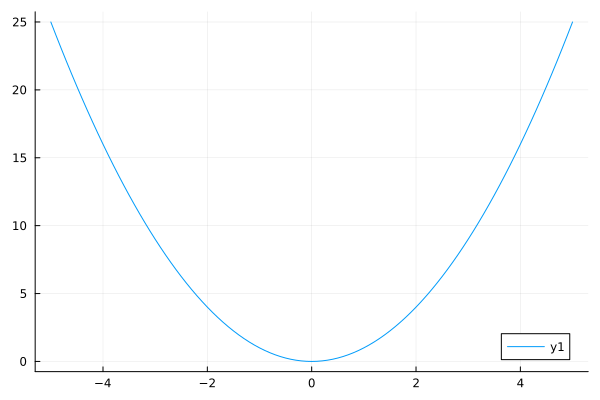

In [31]:
using Plots
plot(-5:0.1:5, x-> x^2)

Alright, so how do we get the minimum? 

Let's use Optim to see how. I'm going to use the Nelder-Mead algorithm, which is generally considered a good local optimization algorithm that does not require a gradient. 

Nelder-Mead is a quick-and-dirty optimization algorithm. If you have a smooth problem with a reasonable gradient, it's probably a little wiser to use an alternative method (more in a bit). 

In [32]:
using Optim

# Define our target function
f(x) = x[1]^2

# Minimize it with Nelder-Mead, the default
res = optimize(f, [1.0])
# res = optimize(f, [1.0], NelderMead()) # Or, to explicitly use Nelder-Mead

# Get the minimizer info
@info "Nelder-Mead optimum" res.minimizer res.minimum Optim.converged(res)

┌ Info: Nelder-Mead optimum
│   res.minimizer = [0.00024414062500016914]
│   res.minimum = 5.960464477547321e-8
│   Optim.converged(res) = true
└ @ Main c:\Users\chadi\OneDrive - Handelshögskolan i Stockholm\GitHub\julia-bootcamp-2022\session-3\optimization-lecture.ipynb:11


In [33]:
# Or you can just print it out for some summary info:
println(res)

 * Status: success

 * Candidate solution
    Final objective value:     5.960464e-08

 * Found with
    Algorithm:     Nelder-Mead

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    10
    f(x) calls:    23



# Concept check!

Let's do some maximum likelihood estimation. Suppose we have $n$ data points we believe were drawn from a four-dimensional Normal distribution with an unknown mean. Assume the variance is the identity matrix for now.

Then we have

$$
\hat \mu = \arg \min_{m} \sum_{i=1}^n \log P(X_n \mid \mu=m, \sigma=I)
$$

How do we find the maximum likelihood estimate? Well, let's use Optim and Nelder-Mead!

# Concept check!

Install the `Distributions` package if you have not already.

Use the code below as a starting point to find the maximum likelihood estimates for the means of the data. The likelihood of a distribution is `logpdf(MvNormal(m, I), data)`.

```julia
# Imports
using Distributions, LinearAlgebra

# Create the true distribution
n = 1000
means = [1.0, 0.0, 3.0, 4.0]
dist = MvNormal(means, I)
xs = rand(dist, n)
```

If you finish quickly, modify this problem to calculate a homoscedastic variance parameter -- i.e. change `dist = MvNormal(means, sigma*I)` and change the `loglike` function to incorporate `sigma` as well. It can be a little tricky, as I'll demonstrate.

In [34]:
# Imports
using Distributions, LinearAlgebra

# Create the true distribution
n = 1000
means = [1.0, 0.0, 3.0, 4.0]
dist = MvNormal(means, I)
xs = rand(dist, n)
loglike(theta) = -sum(logpdf(MvNormal(theta, I), xs));

In [35]:
res = optimize(loglike, zeros(4), Optim.Options(iterations=10_000))
res.minimizer

4-element Vector{Float64}:
  1.0160104751361108
 -0.014629551134563093
  3.0051092893222484
  4.039045203850431

## Warning: check that you actually solved it first!

Optim will let you extract the value `res.minimizer` _even if the problem wasn't solved!_ Make sure to check that you have a solution first!

In [36]:
rosenbrock(x) =  (1.0 - x[1])^2 + 100.0 * (x[2] - x[1]^2)^2
result = optimize(
    rosenbrock, 
    zeros(2), 
    SimulatedAnnealing(), 
    Optim.Options(iterations=1000)
)

 * Status: failure (reached maximum number of iterations)

 * Candidate solution
    Final objective value:     3.243072e-04

 * Found with
    Algorithm:     Simulated Annealing

 * Convergence measures
    |x - x'|               = NaN ≰ 0.0e+00
    |x - x'|/|x'|          = NaN ≰ 0.0e+00
    |f(x) - f(x')|         = NaN ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = NaN ≰ 0.0e+00
    |g(x)|                 = NaN ≰ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    1000
    f(x) calls:    1001


In [37]:
result.minimizer

2-element Vector{Float64}:
 1.0126381993144247
 1.0267190223106875

## Checking convergence

You can check convergence with `converged(res)` or by checking the individual convergence flags:

```julia
converged(res) # Checks all flags
iteration_limit_reached(res)
x_converged(res)
f_converged(res)
g_converged(res)
```

# Optimizing with gradients

Oftentimes you have (or can get) gradients of an objective function. Gradients are extraordinarily useful for smooth (or locally smooth) function optimization, because you can often access significantly more efficient optimization algorithms.

The most common one of these is LBFGS. LBFGS uses the gradient to approximate a Hessian, and then move each value in the direction of a minima using that implied Hessian.

Fortunately, it's super easy to just pick a new algorithm with Optim! Lets try it now returning to our simple quadratic function.

In [38]:
# Minimize it with LBFGS, a common gradient-required method
res = optimize(f, [1.0], LBFGS())
@info "LBFGS optimum" res.minimizer res.minimum Optim.converged(res)

┌ Info: LBFGS optimum
│   res.minimizer = [-6.359357485052897e-13]
│   res.minimum = 4.0441427622698303e-25
│   Optim.converged(res) = true
└ @ Main c:\Users\chadi\OneDrive - Handelshögskolan i Stockholm\GitHub\julia-bootcamp-2022\session-3\optimization-lecture.ipynb:3


Note that `Optim` will default to using finite differences to calculate gradients. Finite differences are numerical, not exact, and are less accurate and prone to numerical errors.

If we wanted to use our shiny new automatic differentiation tools, we could get _exact_ gradients that should speed up our estimation.

Let's try this the "foolproof" way first, then I'll show you how to provide your own gradient if needed.

The foolproof way is to set the keyword `autodiff=:forward`. Only `:finite` or `:forward` are supported -- if you want reverse mode AD, you'll have to wait just a second.

In [39]:
# Minimize it with LBFGS & autodiff
res = optimize(f, [1.0], LBFGS(), autodiff=:forward)
@info "Nelder-Mead optimum" res.minimizer res.minimum Optim.converged(res)

┌ Info: Nelder-Mead optimum
│   res.minimizer = [0.0]
│   res.minimum = 0.0
│   Optim.converged(res) = true
└ @ Main c:\Users\chadi\OneDrive - Handelshögskolan i Stockholm\GitHub\julia-bootcamp-2022\session-3\optimization-lecture.ipynb:3


## Using your own gradients

You can pass in your own gradient functions if you want to use a different AD-backend, or if you have exact derivatives already coded up.

To do so, you need to write a mutating function

```julia
function g!(G, x)
    G[1] = . . .
end
```

that sets each element of `G` to the gradient of your function w.r.t each parameter in `x`.

Recall that our target function here, $f(x) = x^2$, has the derivative $2 x$. We can just write this up!

In [40]:
# Analytic gradient
function g!(G, x)
    G[1] = 2*x[1]
end

g! (generic function with 1 method)

In [41]:
# Minimize it with LBFGS & exact gradient
res = optimize(f, g!, [1.0], LBFGS())
@info "Nelder-Mead optimum" res.minimizer res.minimum Optim.converged(res)

┌ Info: Nelder-Mead optimum
│   res.minimizer = [0.0]
│   res.minimum = 0.0
│   Optim.converged(res) = true
└ @ Main c:\Users\chadi\OneDrive - Handelshögskolan i Stockholm\GitHub\julia-bootcamp-2022\session-3\optimization-lecture.ipynb:3


Suppose now we had a much larger model with a gradient that's too hard (or we are too lazy) to calculate by hand. 

As per the above, we'd maybe want to use ReverseDiff! Let's write a `g!` function that calls `ReverseDiff` for us.

I'm going to use the maximum likelihood example from above, but this time with (a) large dimensionality, good for reverse mode, and (b) a diagonal covariance matrix.

Importantly, the __variance parameters cannot be negative!__. You can do this a couple of ways, such as taking the `exp` of variance parameters, but here I will use box minimization to constrain the optimizer to a region where the sigmas have to be positive.

In [42]:
# Imports
using Distributions, LinearAlgebra

# Create the true distribution
n = 1000
K = 100 # dimensionality
means = randn(K)
variances = rand(InverseGamma(2,3), K)
dist = MvNormal(means, Diagonal(variances))
xs = rand(dist, n);

In [43]:
# Define our target function
function loglike(par)
    return -sum(logpdf(MvNormal(par[1:K], Diagonal(par[K+1:end])), xs))
end

# Define upper/lower bounds so that the variances remain positive
lower = vcat(repeat([-Inf], K), repeat([0],K));
upper = vcat(repeat([Inf], 2K));

In [44]:
# Our gradient function simply calls ReverseDiff for us
tape = ReverseDiff.GradientTape(loglike, zeros(2*K))
g!(G, x) = ReverseDiff.gradient!(G, tape, x)

g! (generic function with 1 method)

In [45]:
# Optimize it!
res = optimize(loglike, g!, lower, upper, ones(K*2), Fminbox(LBFGS()))

 * Status: success

 * Candidate solution
    Final objective value:     1.754645e+05

 * Found with
    Algorithm:     Fminbox with L-BFGS

 * Convergence measures
    |x - x'|               = 3.23e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.23e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 4.63e-06 ≰ 1.0e-08

 * Work counters
    Seconds run:   80  (vs limit Inf)
    Iterations:    7
    f(x) calls:    1992
    ∇f(x) calls:   1992


# JuMP

Optim is great for relatively easy problems, but sometimes you need to work with a lot of constraints, integer variables, etc. 

This is where JuMP comes in.

# JuMP

JuMP is technically a _domain specific language_, or DSL. 

A DSL is essentially an applied programming language for a specific task -- in the case of JuMP, this is defining and solving optimization problems.

JuMP allows you to write arbitrary problems, and then hand those problems off to a relatively large library of solvers.

JuMP has an _amazing_ community. If you've got optimization problems, the JuMP community can probably help.

## JuMP Solvers

JuMP supports lots of solvers, all of which permit you to work on different types of problems. Some solvers are faster than others or may require a license (like Knitro or Gurobi, which are available on the Stanford yens/sherlock).

A list of solvers is available [here](https://jump.dev/JuMP.jl/stable/installation/#Supported-solvers).

You have to install a solver as an additional package -- for example, let's pick the `Clp` solver. It solves linear programs (the simple ones) so it'll be a good demo for us.

In [46]:
import Pkg; Pkg.add(["JuMP", "Clp", "HiGHS", "Ipopt"])

   Resolving package versions...
  No Changes to `C:\Users\chadi\OneDrive - Handelshögskolan i Stockholm\GitHub\julia-bootcamp-2022\Project.toml`
  No Changes to `C:\Users\chadi\OneDrive - Handelshögskolan i Stockholm\GitHub\julia-bootcamp-2022\Manifest.toml`


# A simple example

I'm more or less copying this from JuMP's [spectacular documentation](https://jump.dev/JuMP.jl/stable/tutorials/getting_started/getting_started_with_JuMP/#Getting-started-with-JuMP), so refer there for more information if JuMP is a thing you think you'll end up using.

Suppose we have the simple linear program 

![](problem.png)

Let's write this as a JuMP model.

In [47]:
# Import our packages.
using JuMP
using Clp

# Set up a 'model', which is a bucket to hold your problem definition.
# Use OptimizerPackage.Optimizer to use another solver, i.e. HiGHS.Optimizer
model = Model(Clp.Optimizer) 

# Add our variables
@variable(model, x >= 0)
@variable(model, 0 <= y <= 3)

# Set the objective function
@objective(model, Min, 12x + 20y)

# Write our constraints
@constraint(model, c1, 6x + 8y >= 100)
@constraint(model, c2, 7x + 12y >= 120)

print(model)

Min 12 x + 20 y
Subject to
 c1 : 6 x + 8 y >= 100
 c2 : 7 x + 12 y >= 120
 x >= 0
 y >= 0
 y <= 3


In [48]:
# Now we solve it!
optimize!(model)

Coin0506I Presolve 2 (0) rows, 2 (0) columns and 4 (0) elements
Clp0006I 0  Obj 0 Primal inf 22.5 (2)
Clp0006I 2  Obj 205
Clp0000I Optimal - objective value 205
Clp0032I Optimal objective 205 - 2 iterations time 0.002


In [49]:
# Show some stats on the solution
@show termination_status(model)
@show primal_status(model)
@show dual_status(model)
@show objective_value(model)
@show value(x) # Extracts the value of x
@show value(y) # Extracts the value of y
@show shadow_price(c1)
@show shadow_price(c2);

termination_status(model) = MathOptInterface.OPTIMAL
primal_status(model) = MathOptInterface.FEASIBLE_POINT
dual_status(model) = MathOptInterface.FEASIBLE_POINT
objective_value(model) = 205.0
value(x) = 14.999999999999995
value(y) = 1.2500000000000036
shadow_price(c1) = -0.25
shadow_price(c2) = -1.5


In [50]:
# Save our solution to disk
write_to_file(model, "model.mps")

# Read it from disk
model = read_from_file("model.mps")

A JuMP Model
Minimization problem with:
Variables: 2
Objective function type: AffExpr
`AffExpr`-in-`MathOptInterface.GreaterThan{Float64}`: 2 constraints
`VariableRef`-in-`MathOptInterface.GreaterThan{Float64}`: 1 constraint
`VariableRef`-in-`MathOptInterface.Interval{Float64}`: 1 constraint
Model mode: AUTOMATIC
CachingOptimizer state: NO_OPTIMIZER
Solver name: No optimizer attached.

## Checking solution status

It's generally a good idea to check to make sure your model actually solved. Unlike Optim, JuMP will throw an error if you try to retrieve optimal values if the solver failed, but you shouldn't rely on errors from anything to notify you of estimation failures.

Use `termination_status(model)` or `primal_status(model)` to get the status -- you can see all the termination codes in [the docs](https://jump.dev/JuMP.jl/stable/moi/reference/models/#MathOptInterface.ResultStatusCode).

JuMP exports all-caps variables following the name of terminations codes, i.e. `INFEASIBLE`, `OPTIMAL`, etc. are all valid variables after calling `Optim.jl`.

In [51]:
model = Model(Clp.Optimizer)

@variable(model, 0 <= x <= 1)
@variable(model, 0 <= y <= 1)
@constraint(model, x + y >= 5)
@objective(model, Max, x - y)
optimize!(model)

termination_status(model) == INFEASIBLE

Coin0507I Presolve determined that the problem was infeasible with tolerance of 1e-08
Clp3003W Analysis indicates model infeasible or unbounded
Clp0006I 0  Obj 0 Primal inf 4.9999999 (1) Dual inf 0.9999999 (1)
Clp0006I 1  Obj -3 Primal inf 2.9999999 (1)
Clp0001I Primal infeasible - objective value -3
Clp0032I PrimalInfeasible objective -3 - 1 iterations time 0.002


true

## Solver attributes

You can change the behavior of different solvers with `set_solver_attribute(model, "name_of_attribute", value)`. This can often help you debug issues if solvers aren't converging.

All solvers have different attributes! You'll need to look up the ones specific to your solver.

Let's look at [the attributes](https://github.com/jump-dev/Clp.jl) for `Clp.jl`.

In [52]:
model = Model(Clp.Optimizer)
set_optimizer_attribute(model, "LogLevel", 4)

@variable(model, 0 <= x <= 1)
@variable(model, 0 <= y <= 1)
@constraint(model, x + y >= 5)
@objective(model, Max, x - y)
optimize!(model)

Coin0502I Problem is infeasible due to row 0, 5 1.797693134862316e+308
Coin0507I Presolve determined that the problem was infeasible with tolerance of 1e-08
Clp0033I Presolve took 0.00 seconds (total 0.00)
Clp3003W Analysis indicates model infeasible or unbounded
Clp1001I Initial range of elements is 1 to 1
Clp1004I Not bothering to scale as good enough
Clp0022I Absolute values of scaled rhs range from 5 to 5, minimum gap 1e+100
Clp0020I Absolute values of scaled objective range from 1 to 1
Clp0021I Absolute values of scaled bounds range from 1 to 1, minimum gap 1
Clp0060I Primal error 0, dual error 0
Clp0060I Primal error 0, dual error 0
Clp0006I 0  Obj 0 Primal inf 4.9999999 (1) Dual inf 0.9999999 (1)
Clp0060I Primal error 0, dual error 0
Clp0060I Primal error 0, dual error 0
Clp0006I 1  Obj -3 Primal inf 2.9999999 (1)
Clp0001I Primal infeasible - objective value -3
Clp0033I Dual took 0.00 seconds (total 0.00)
Clp0032I PrimalInfeasible objective -3 - 1 iterations time 0.002


## Variables and domain constraints

You can specify most inequality constraints:


In [53]:
model = Model()
@variable(model, x_free)
@variable(model, x_lower >= 0)
@variable(model, x_upper <= 1)
@variable(model, 2 <= x_interval <= 3)
@variable(model, x_fixed == 4)
print(model)

Feasibility
Subject to
 x_fixed == 4
 x_lower >= 0
 x_interval >= 2
 x_upper <= 1
 x_interval <= 3


## Vector/matrix variables

Oftentimes you have parameters in a vector format $[x_1, x_2, \dots, x_k]$. In JuMP, this is very easy to specify:

In [54]:
model = Model()

n = 10
@variable(model, x[1:n]) # Make x a length 5 vector
@variable(model, y[1:n, 1:n]) # Make y a 5x5 array

model

A JuMP Model
Feasibility problem with:
Variables: 110
Model mode: AUTOMATIC
CachingOptimizer state: NO_OPTIMIZER
Solver name: No optimizer attached.
Names registered in the model: x, y

## Vector constraints

You can add vector/matrix constraints by _labelling_ a dimension and using that dimension in the inequalities:

In [55]:
model = Model()
bounds = rand(3)
@variable(model, sqrt(i) <= x[i = 1:3] <= i^2)
@variable(model, y[i = 1:3] <= bounds[i])

3-element Vector{VariableRef}:
 y[1]
 y[2]
 y[3]

## Integer/binary variables

Just add the type of your variable at the end of the `@variable` call:


In [56]:
model = Model()
@variable(model, x_binary, Bin) # true/false 0/1 only.
@variable(model, x_int, Int) # Any integer
@variable(model, 0 <= x_int_limited <= 5, Int) # only {0,1,2,3,4,5}

x_int_limited

## Positive semidefinite and symmetric matrix variables

If you're trying to do something like optimize a maximum likelihood estimate of a covariance matrix, you may want to flag the matrix as PSD (or symmetric in other problems) to avoid errors.

In [57]:
model = Model()
n = 10
@variable(model, Σ[1:n, 1:n], PSD) # For positive semi-definite
@variable(model, Ω[1:n, 1:n], Symmetric); # For symmetric

## Constraints

You can add a _lot_ of constraint types to your problem. Take the following for example:

In [58]:
using Ipopt
model = Model(Ipopt.Optimizer)
@variable(model, x[1:5])
@variable(model, 0 <= q[1:5] <= 1)
@constraint(model, q'x <= 15)
@constraint(model, sum(q) == 1)
@constraint(model, q[5]*x[1] + 2*x[3] <= x[2] * x[5])
@NLconstraint(model, sqrt(sum(x[i]*q[i+1] for i in 1:2)) <= 100)
@objective(model, Max, q'x)

print(model)

Max q[1]*x[1] + q[2]*x[2] + q[3]*x[3] + q[4]*x[4] + q[5]*x[5]
Subject to
 q[1] + q[2] + q[3] + q[4] + q[5] == 1
 q[1]*x[1] + q[2]*x[2] + q[3]*x[3] + q[4]*x[4] + q[5]*x[5] <= 15
 q[5]*x[1] - x[2]*x[5] + 2 x[3] <= 0
 q[1] >= 0
 q[2] >= 0
 q[3] >= 0
 q[4] >= 0
 q[5] >= 0
 q[1] <= 1
 q[2] <= 1
 q[3] <= 1
 q[4] <= 1
 q[5] <= 1
 sqrt(x[1] * q[2] + x[2] * q[3]) - 100.0 <= 0


## Programmatic constraints

Since this is all just Julia code, you can add constraints programmatically:

In [59]:
model = Model()

@variable(model, z[1:10])
x = randn(10)

for i in 1:length(x)
    if x[i] <= 0
        @constraint(model, 0 <= z[i])
    end
end

print(model)

Feasibility
Subject to
 -z[2] <= 0
 -z[6] <= 0
 -z[7] <= 0
 -z[9] <= 0


# Concept check!

Let's look at an example near and dear to my heart, portfolio optimization! Borrowed, of course, from the [JuMP docs](https://jump.dev/JuMP.jl/stable/tutorials/nonlinear/portfolio/).

Suppose we had some stocks that followed a known distribution 

```julia
# Set up return distribution
using Random; Random.seed!(15)
n_stocks = 10
μ = rand(MvNormal(zeros(n_stocks), 0.1I))
Σ = rand(InverseWishart(n_stocks, diagm(ones(n_stocks))))
```

## Concept check!

We have an investor who wants to allocate their wealth to each of these stocks so as to minimize their portfolio risk while setting the return to a desired expected return $R$:

$$
\begin{align*}
\min_{q_i} \quad & q'\Sigma q \\
    s.t.         & \sum_i^N q_i = 1   \\
                 & q'\mu = R  \\
                 & q_i \in [-1,1] \forall i
\end{align*}
$$

Use `JuMP` and the solver `Ipopt` to calculate the optimal portfolio for this investor and this economy.

__Bonus points:__ Wrap your JuMP code in a function called `opt_portfolio(R)` that returns a tuple `(q'Σ*q, q'μ)`. Use `Plots.jl` to plot the efficient frontier (expected return for a given minimum variance portfolio). This is commonly done with the variance on the x-axis and the return on the y-axis.

In [60]:
# Set up return distribution
using Random; Random.seed!(15)
n_stocks = 10
μ = rand(MvNormal(zeros(n_stocks), 0.1I))
Σ = rand(InverseWishart(n_stocks, diagm(ones(n_stocks))))

function opt_portfolio(R)
    portfolio = Model(Ipopt.Optimizer)
    set_silent(portfolio)
    @variable(portfolio, -1 <= q[1:n_stocks] <= 1)
    @objective(portfolio, Min, q' * Σ * q)
    @constraint(portfolio, sum(q) == 1)
    @constraint(portfolio, q'μ == R)
    optimize!(portfolio)
    q_star = value.(q)
    
    return q_star'Σ*q_star, q_star'μ
end

# Extract the optimal values
rs = collect(range(-1, 1.0, length=100))
ys = map(opt_portfolio, rs);



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



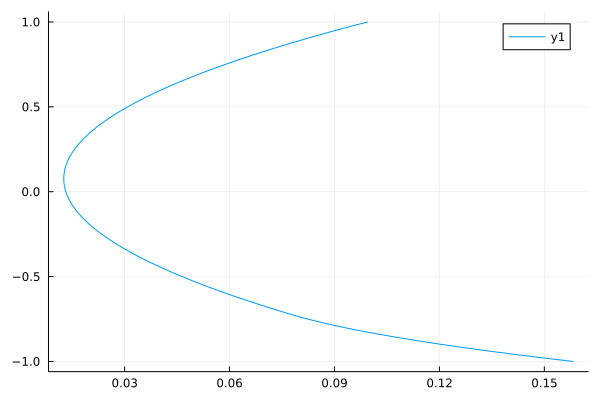

In [61]:
using Plots
plot(ys)

## Any closing questions?